In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

In [12]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [13]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    
def plot_loghist(x, bins, **kwargs):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, **kwargs)
    plt.xscale('log')
    
def plot_metrics_histogram(report, **hist_kwargs):
    plt.figure(figsize=(20, 20))
    for idx, metric in enumerate(report.columns[1:], 1):
        plt.subplot(3, 2, idx)
        plot_loghist(report[metric], bins=50)
        plt.xlabel(metric, size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xscale('log')
        plt.grid()
    plt.show()

34299


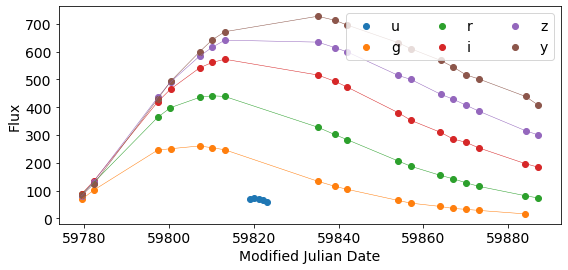

43812


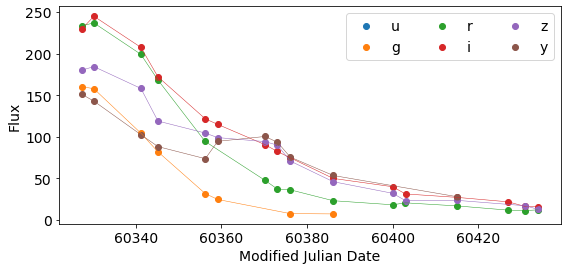

70046


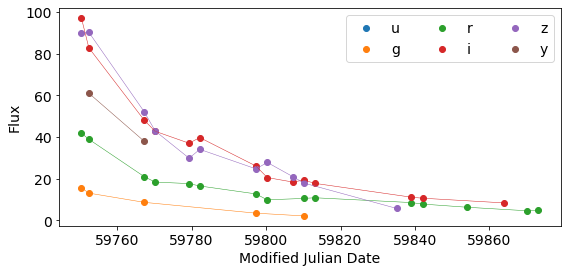

84716


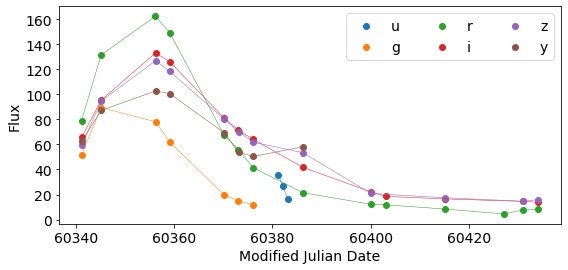

131629


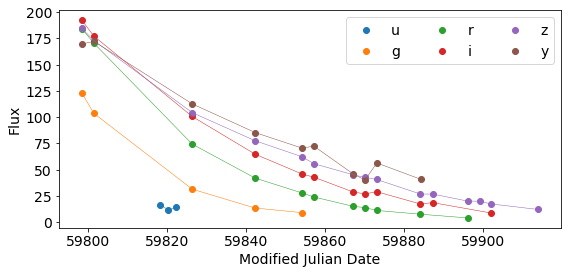

169315


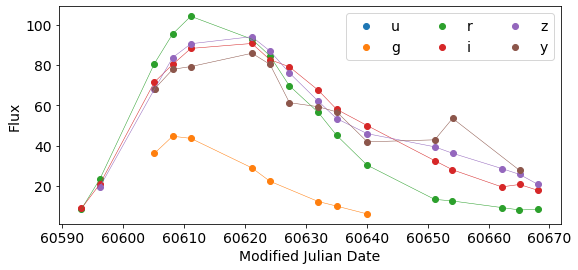

229855


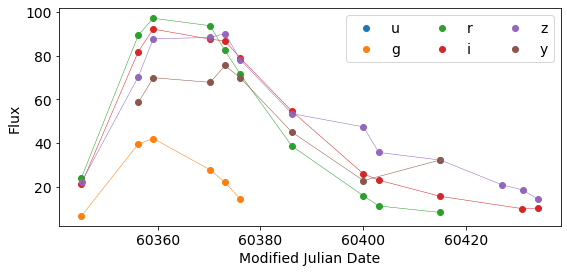

251430


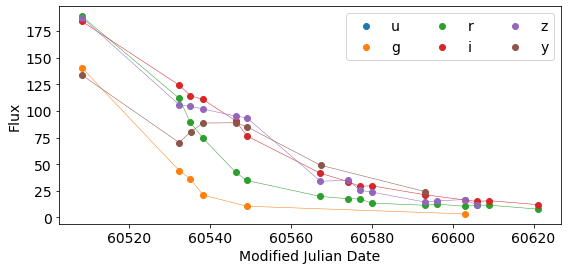

282714


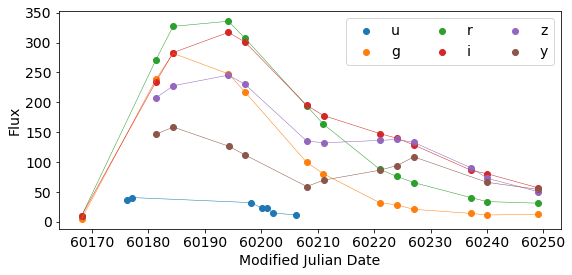

290682


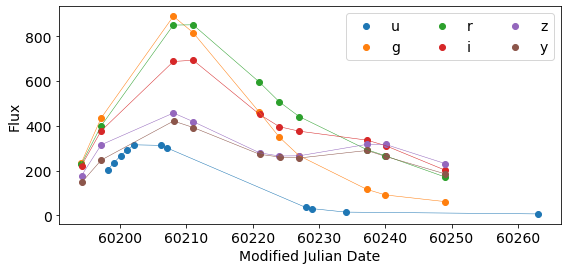

316306


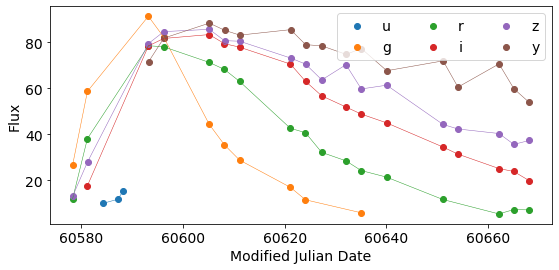

In [14]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

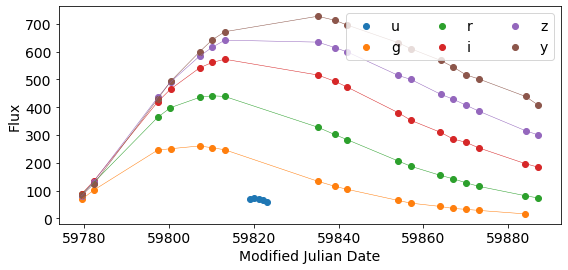

In [59]:
anobject = get_object(data, 34299)

plot_light_curves(anobject)

In [60]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [61]:
import importlib
importlib.reload(rbfnet_aug)

<module 'rbfnet_aug' from '/home/sysak_ma/Desktop/Study/Diploma/light_curve_approx/notebooks/rbfnet_aug.py'>

In [62]:
import rbfnet_aug

# fit augmentation model
model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=30, lam=0., n_epochs=1000, lr=0.03, batch_size=100)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                 anobject['mjd'].max(), n_obs=1000)

In [63]:
anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                 flux_err_pred, anobject_test['passband'].values)
anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)

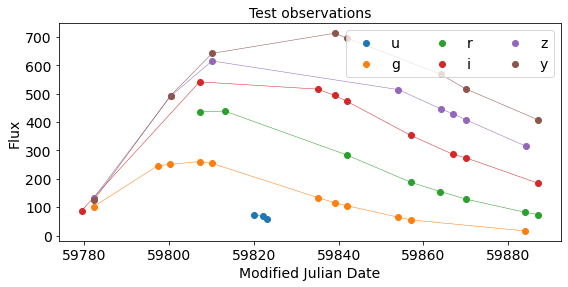

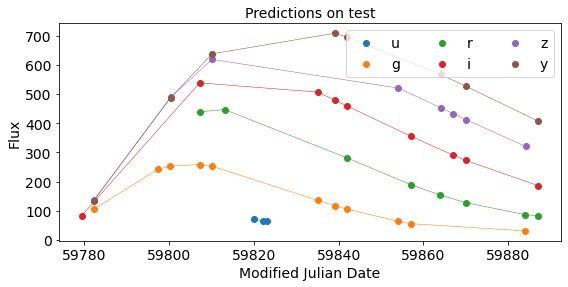

In [64]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

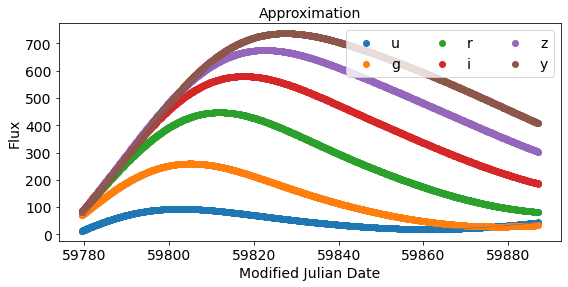

In [65]:
plot_light_curves(anobject_aug, "Approximation")

In [66]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  5.647685368828623
MAE:  4.361924633461803
RSE:  0.02850641534245234
RAE:  0.02490907659325778
MAPE:  3.8949391041201484


# Test on many objects

In [67]:
import tqdm

In [68]:
good_object_ids = [i for i in tqdm.tqdm(object_ids) if is_good(get_object(data, i))]

100%|██████████| 7848/7848 [00:30<00:00, 254.31it/s]


In [69]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in tqdm.notebook.tqdm(good_object_ids):
    
    # get an object
    anobject = get_object(data, i)
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)    
    
    # fit augmentation model
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=40, lam=0., n_epochs=200, lr=0.02, batch_size=100)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)
    
    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)
    anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, 
                                     flux_err_pred, anobject_test['passband'].values)
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                      anobject_test_pred['flux'].values)
    report.loc[len(report), :] = [i] + list(metrics)
np.round(report.mean(), 2)

ID      340898.23
RMSE        21.67
MAE         13.30
RSE          0.25
RAE          0.20
MAPE        22.47
dtype: float64

In [70]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,14.976,7.75717,0.286093,0.209783,18.9466
1,1124,4.72802,3.29601,0.127157,0.12314,21.5958
2,1920,21.7892,16.5369,0.352267,0.330815,46.5676
3,2922,20.2207,10.1409,0.292222,0.288106,42.6808
4,4173,4.1532,2.93774,0.0837619,0.0715876,10.6624
...,...,...,...,...,...,...
511,339169,3.26551,2.24294,0.21945,0.173605,10.2546
512,341653,6.41408,5.0262,0.215082,0.198549,10.9423
513,342659,12.6057,6.3763,0.370973,0.229034,26.7735
514,8366012,46.6759,31.2065,0.382701,0.283386,60.9248


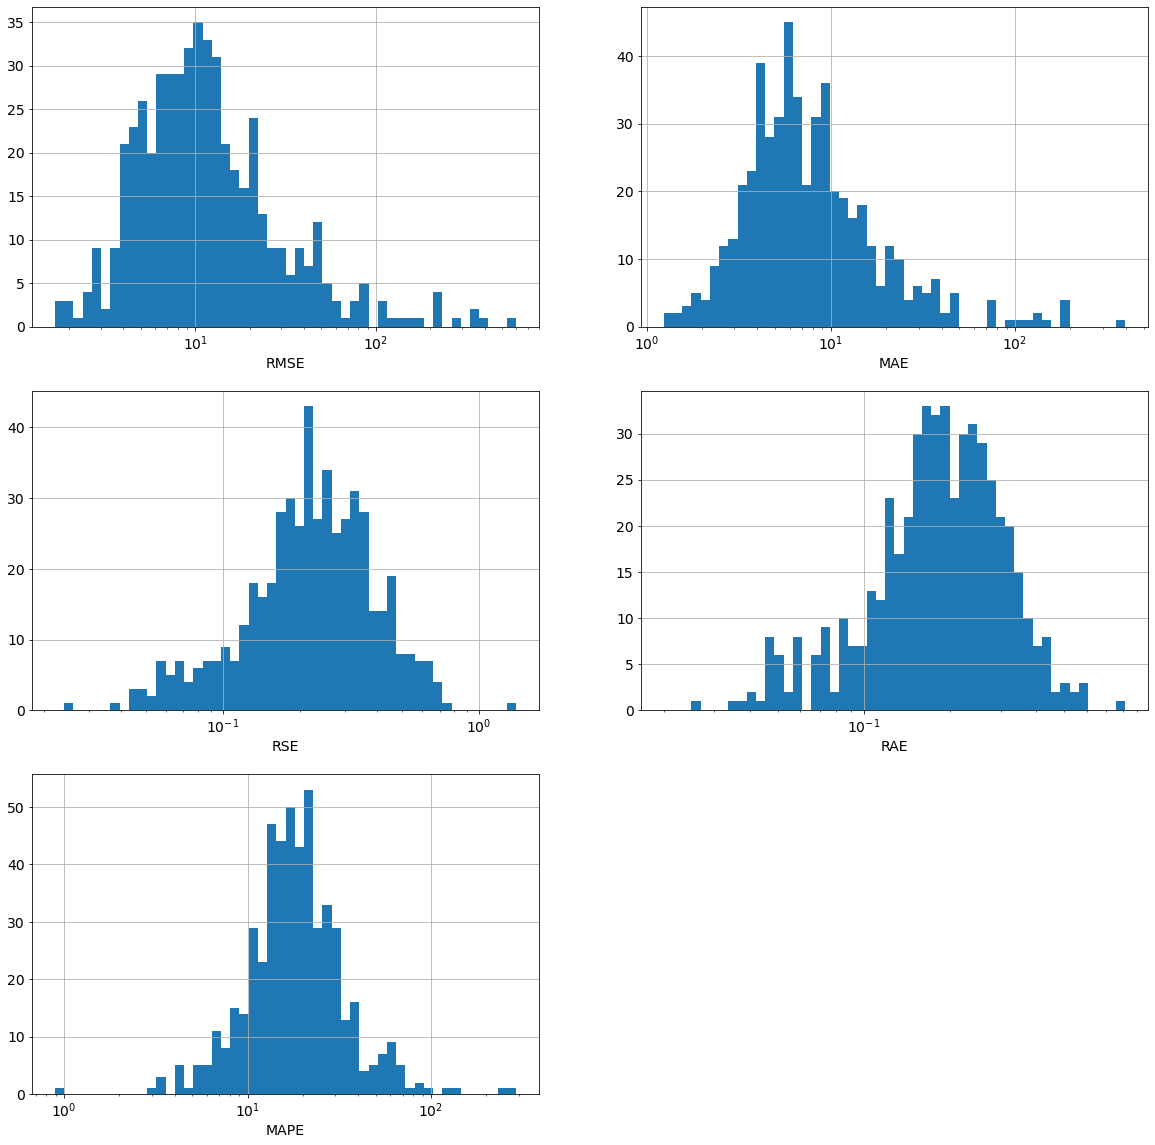

In [71]:
plot_metrics_histogram(report)

34299


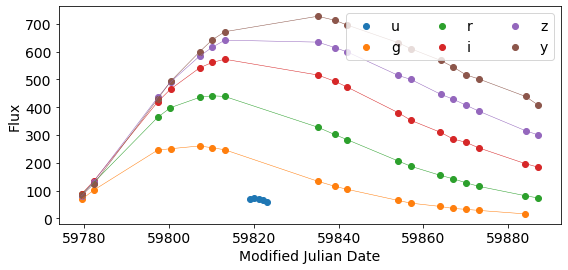

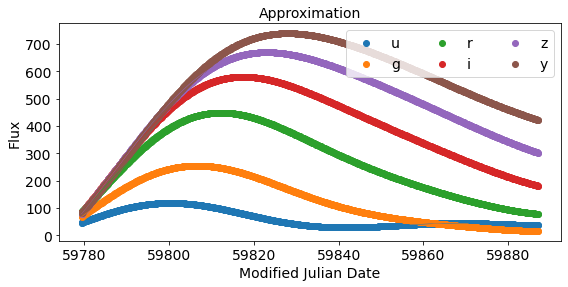

43812


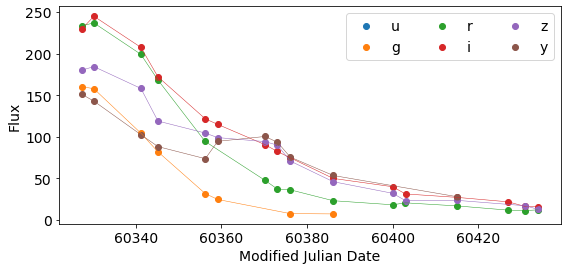

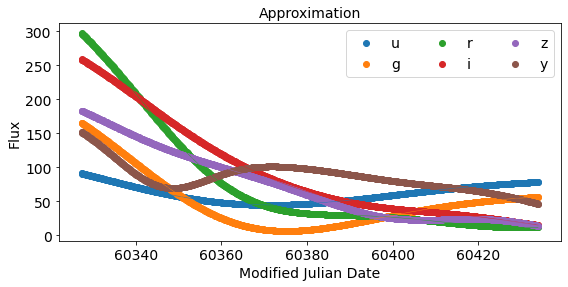

70046


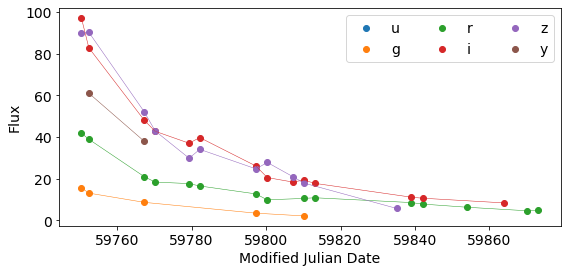

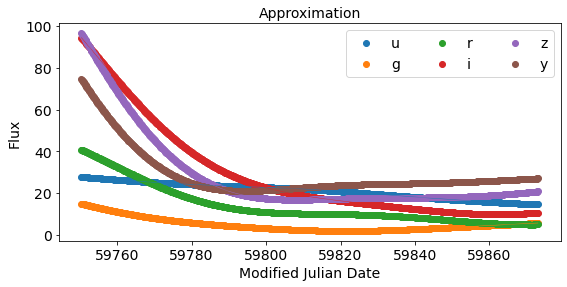

84716


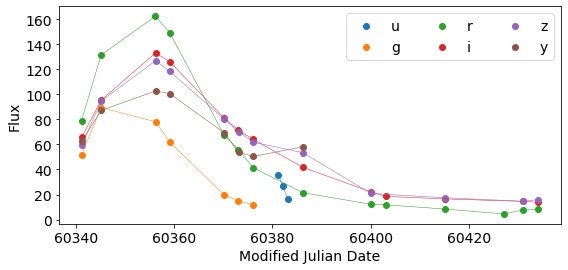

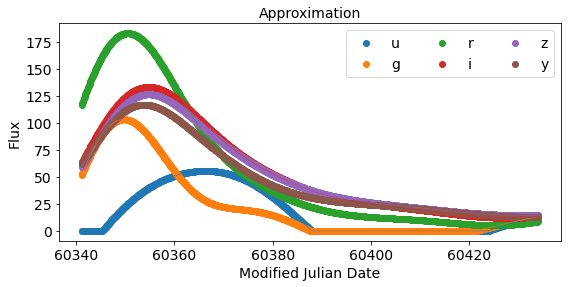

131629


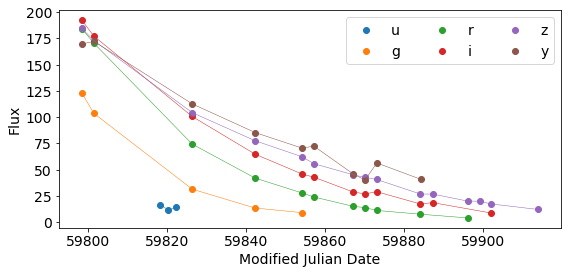

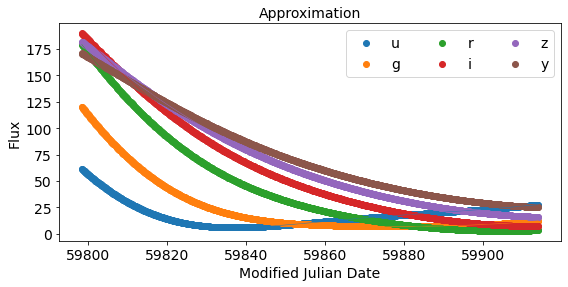

169315


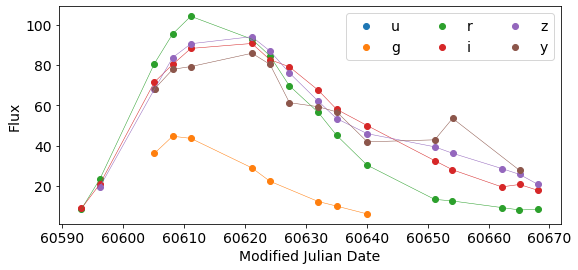

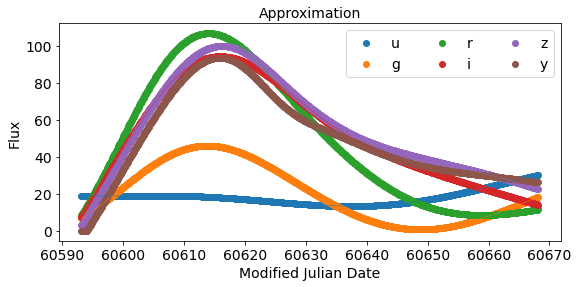

229855


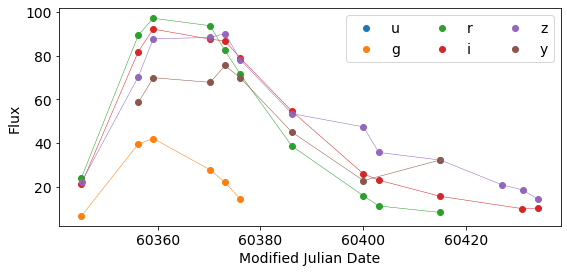

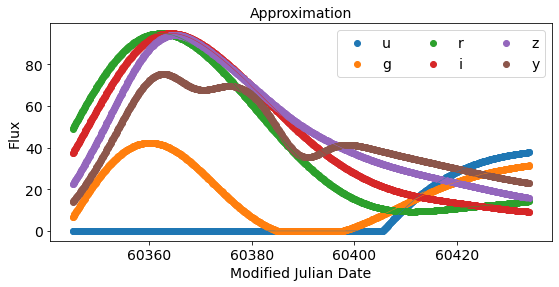

251430


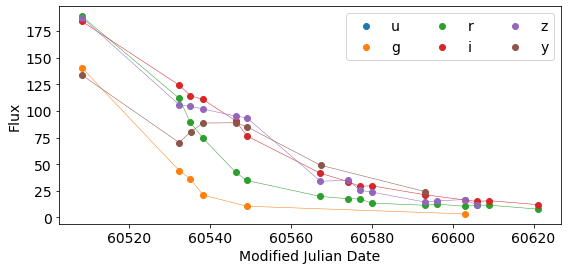

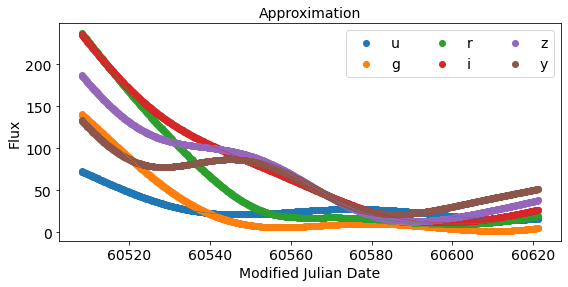

282714


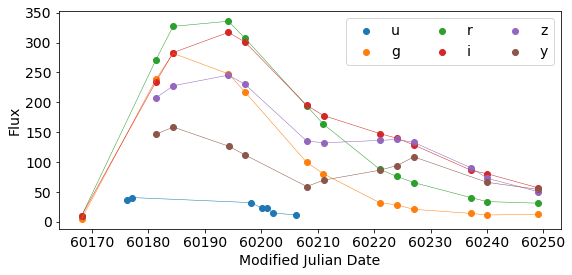

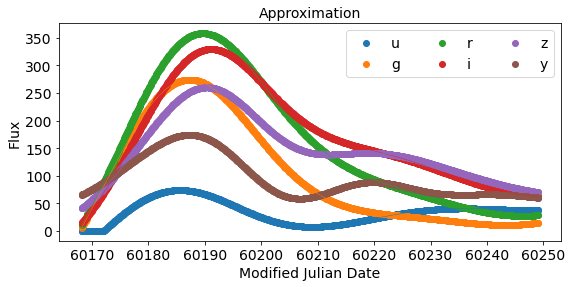

290682


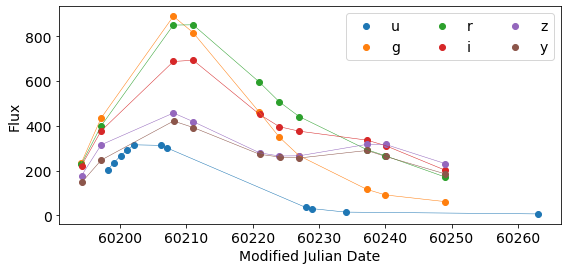

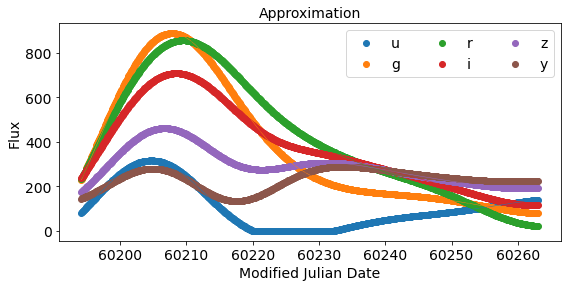

316306


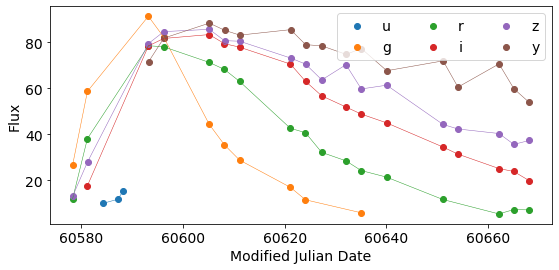

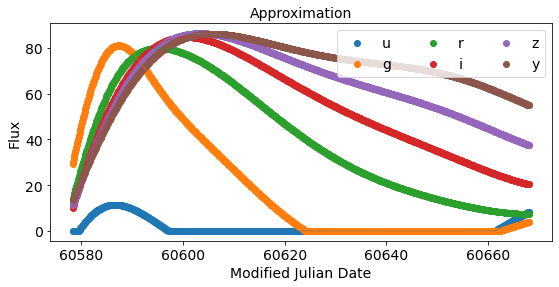

In [72]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()
    
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    model = rbfnet_aug.RBFNetAugmentation(passband2lam, n_hidden=200, lam=0., n_epochs=300, lr=0.01, batch_size=100)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                     anobject['mjd'].max(), n_obs=1000)
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    plot_light_curves(anobject_aug, "Approximation")
    plt.show()